# Dielectric fitting program
This program opens an Excel file processed by `Origin C derivative program` or `Text to Excel file.ipynb` program and fit dielectric constants (either $\varepsilon''_{der}$ or $\varepsilon'$).  
With Origin C program, data from Origin should be copied and pasted into each sheet (select all and paste from the cell A1) named as temperature (e.g. 100C) in an Excel file. Please see the example Excel file.  
#### *Please read `How to use` at the end of the program, which is a guide of this program.*

Sheet names:
 ['230C', '220C', '210C', '200C', '190C', '180C', '170C', '160C', '150C', '140C', '130C', '120C', '110C', '100C', '90C', '80C', '70C', '60C', '50C', '40C', '30C', '20C', '10C', '0C', '-10C', '-20C', '-10C (2)', '0C (2)', '10C (2)', '20C (2)', '30C (2)', '40C (2)', '50C (2)', '60C (2)', '70C (2)', '80C (2)', '90C (2)', '100C (2)', '110C (2)', '120C (2)', '130C (2)', '140C (2)', '150C (2)', '160C (2)', '170C (2)', '180C (2)', '190C (2)', '200C (2)', '210C (2)', '220C (2)', '230C (2)'] 

Columns:
 ['LogFrequency', 'Constant', 'Loss', 'DerivLoss', 'TanD', 'Conduct', 'Iconduct', "Modulus'", "Modulus''", 'DoubleLnLoss', 'Frequency', 'wFrequency', 'Summary'] 

The temperature of the processing data is: 120C (2)


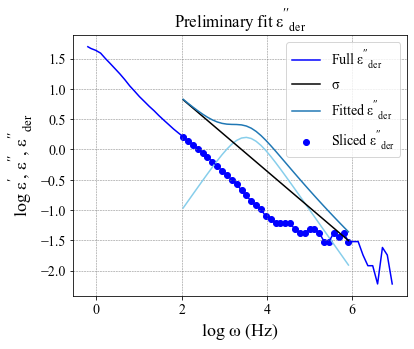

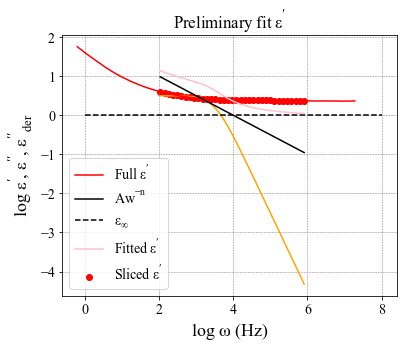

Markers are data within fitting range.
Lines are the whole data.



In [26]:
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
import os

####################################################################################
####################################################################################
####################################################################################
####################################################################################
############################### You can edit below #################################
####################################################################################
####################################################################################
####################################################################################
####################################################################################
####################################################################################

##### file name to process, use .xlsx file #####
filename = '2-4C18SO2CH3_1107 all data.xlsx'

##### Determine temperature by selecting a sheet.
##### Put the name of the sheet from printed sheet lists
wb_name = '120C (2)'

##### decide the number of point to cut for fitting
# high and low ANGULAR FREQUENCY limit in LOG10
# make sure the low frequency range ends in the middle of slope
fit_highf = 6
fit_lowf = 2

# slice high frequency range of the raw data to plot in log10
# usually do not need to change
raw_highf = np.log10(3e6)

### find initial guesses and determine inputs here ###
# This has to be less than or equal to your guesses
peak_number = 1

############### guesses for eps_real part ###############
# dielectric constant at the very high frequency in log
eps_inf = 0
eps_inf_width = 2 # bound

# LOG10 base (A) and power (n2) of polarization term (related to real part)
A = 2 # LOG10
A_range = (A - 3, A + 3) # bound

n2 = 0.5  # high n -> higher slope?
#n2_range = (n2 - 0.5, n2 + 0.5) # bound
n2_range = (0.3, 2) # bound
#########################################################

############# guesses for eps_imag_der part #############
# angular frequency guess in log10
# where you think the peaks are
log_freq_guess = [3.5, 3]
log_freq_width = 3 # bound

tau_HN = []
for item in log_freq_guess:
    tau_HN.append(-1*item)

tau_HN_width = log_freq_width 

# guess of dielectric power (del_eps) of each peak in log10
del_eps = [0.5, 1]
del_eps_width = 4 # bound range [+x, -x]

# asymmetric terms (a, b) of HN relation
a = [1, 1]
b = [1, 1]
asymm_range = (0,1) # bound for a and b

# sigma term (imaginary polarization)
sig = -6.5  # high sig -> higher y axis
sig_range = (sig-3, sig+3) # bound

# power (n) of sigma term (related to imaginary part)
n = 0.6  # high n -> higher slope?
#n_range = (n-0.1, n+0.1) # bound
n_range = (0, 2.5) # bound
########################################################

# adjust axis limits based on temperature, get temp from wb_name
temp = float(wb_name.split(' ')[0][:-1])

# change plot axis range here
x_low = -1
x_high = 8
# set ylim values
if temp > 0:
    y_low = -1
    y_high = 6.5
else:
    y_low = -2
    y_high = 5.5

# to save all the results (figures, data points, and parameters)
# True to save
# False not to save
save_results = True

# if the algorightm is not converging, try a different one in the list here
# Note: Some of these do not handle the bounds. I recommend mainly sticking 
# to SLSQP and L-BFGS-B but any of them should get you to the same result
choices = ['SLSQP','TNC','Nelder-Mead','Powell','CG','BFGS','L-BFGS-B','COBYLA']
algorithm = choices[0]

# if the algorithm needs more iternations you can increase it here
iterations = 3000

####################################################################################
####################################################################################
####################################################################################
####################################################################################
########################### DO NOT EDIT CONTENTS BELOW #############################
####################################################################################
####################################################################################
####################################################################################
####################################################################################
####################################################################################


######################## process the data and variables ############################
# open Excel file
wb = openpyxl.load_workbook(filename=filename)

# access to a sheet by index or sheet name
ws = wb[wb_name] # wb.worksheets[wb_index-1] # or ws = wb['(number)C']
temperature = wb_name

# get column names
columns = []
for rows in ws.iter_rows(max_row=1, values_only=True):
    columns = list(rows)
    
# print sheet, column names
print('Sheet names:\n', wb.sheetnames,'\n')
print('Columns:\n',columns,'\n')
print("The temperature of the processing data is:", temperature)

# worksheet to dataframe
# save the worksheet as a dataframe
# change type to numbers
# values (-- or >= 0) change into np.nan
data = pd.DataFrame(ws.values, columns=columns)[4:].reset_index(drop=True).drop(['Summary'], axis=1)
for columns in data.columns.values:
    if columns != 'LogFrequency': 
        data.loc[data[columns] == '--', columns] = np.nan
        data.loc[data[columns] <= 0, columns] = np.nan
data = data.apply(pd.to_numeric, errors='ignore').copy()

# control the length for loop in the functions
del_eps = del_eps[:peak_number]

# variables to np array
log_freq = data.iloc[:, 0].to_numpy()
eps_real = np.array(data.iloc[:, 1])
eps_imag = np.array(data.iloc[:, 2])
eps_imag_der = np.array(data.iloc[:, 3])

# slice raw data to plot to frequency < raw_highf
new_ind_raw = log_freq <= raw_highf
log_freq = log_freq[new_ind_raw]
eps_real = eps_real[new_ind_raw]
eps_imag = eps_imag[new_ind_raw]
eps_imag_der = eps_imag_der[new_ind_raw]
log_ang_freq = log_freq + np.log10(2*np.pi)
log_eps_real = np.log10(eps_real)
log_eps_imag = np.log10(eps_imag)
log_eps_imag_der = np.log10(eps_imag_der)

# slice data to fit
new_ind_fit = (log_ang_freq <= fit_highf) & (log_ang_freq >= fit_lowf)

eps_real_slice = eps_real[new_ind_fit]
eps_imag_slice = eps_imag[new_ind_fit]
eps_imag_der_slice = eps_imag_der[new_ind_fit]
log_ang_freq_slice = log_ang_freq[new_ind_fit]

log_freq_slice = log_freq[new_ind_fit]
log_eps_real_slice = np.log10(eps_real_slice)
log_eps_imag_slice = np.log10(eps_imag_slice)
log_eps_imag_der_slice = np.log10(eps_imag_der_slice)

# decide x and y to fit and plot
w = log_ang_freq_slice
x = w

y_real = log_eps_real_slice
y_imag_der = log_eps_imag_der_slice
y_imag = log_eps_imag_slice

x_full = log_ang_freq
x_for_plot = log_ang_freq
####################################################################################

########### functions to plot preliminary curves based on initial guesses ##########
# set default font style and size globally in matplotlib
plt.rc('text', usetex=False)
plt.rc('font', family='Times New Roman', weight='normal', size='14')
plt.rc('mathtext', default='regular')

def plot_preliminary_real():
    # plot dielectric from function
    HN_real_sim = eps_real_function(w, del_eps, tau_HN, a, b, eps_inf, sig, A, n, n2)
    # each peak
    for i in range(peak_number):
        HN_real_sim_peak = HN_eqn_real(x, del_eps[i], tau_HN[i], a[i], b[i])
        plt.plot(x, np.log10(HN_real_sim_peak), c='orange')
    # plot range of data sliced
    plt.scatter(log_ang_freq_slice, log_eps_real_slice, c='r', label="$Sliced\;\u03B5'$")
    plt.plot(log_ang_freq, log_eps_real, c='r', label="$Full\; \u03B5'$")
    plt.plot(x, np.log10(pol_term(x, A, n2)), c='k', label='$Aw^{-n}$')
    plt.plot((0, 8), (eps_inf, eps_inf), 'k--', label='$\u03B5_\infty$')
    plt.plot(w, np.log10(HN_real_sim), c='pink', label="$Fitted\;\u03B5'$")
    plt.title("$Preliminary\;fit\;\u03B5'$")
    
def plot_preliminary_imag():
    # plot dielectric from function
    HN_imag_sim = eps_imag_function(w, del_eps, tau_HN, a, b, eps_inf, sig, A, n, n2)
    # each peak
    for i in range(peak_number):
        HN_imag_sim_peak = HN_eqn_imag(x, del_eps[i], tau_HN[i], a[i], b[i])
        plt.plot(x, np.log10(HN_imag_sim_peak), c='skyblue')

    # plot range of data sliced
    plt.scatter(log_ang_freq_slice, log_eps_imag_der_slice, c='b', label="$Sliced\;\u03B5''_{der}$")
    plt.plot(log_ang_freq, log_eps_imag_der, c='b', label="$Full\; \u03B5''_{der}$")
    plt.plot(x, np.log10(sig_term(x, sig, n)), c='k', label="$\sigma$")
    plt.plot(x, np.log10(HN_imag_sim), label="$Fitted\;\u03B5''_{der}$")
    plt.title("$Preliminary\;fit\;\u03B5''_{der}$")

def plot_options():
    #plt.ylim(y_low, y_high)
    #plt.xlim(x_low, x_high)
    plt.legend()
    plt.ylabel("$log$ $\u03B5'$, $\u03B5''$, $\u03B5''_{der}$", fontsize=18)
    plt.xlabel("$log$ $\u03C9$ (Hz)", fontsize=18)
    plt.grid(b=None, which='major', axis='both', color='grey', linestyle='--', linewidth=0.5)
####################################################################################

########################### functions related to equations #########################
# functions to use and plot with parameters
def HN_eqn(w, del_eps, tau_HN, a, b):
    """
    Those parameters are numbers
    w: log10 angular frequency
    del_eps: log10 dielectric power
    tau_HN: relaxation time defined by wtau_HN = 1
    a, b: symmetric and asymmetric stretching parameters
    """
    return (10**del_eps)/((1 + (1j*(10**w)*(10**tau_HN))**a)**b)

def HN_eqn_multi(w, del_eps, tau_HN, a, b):
    """
    Those parameters are lists
    del_eps: log10 dielectric power
    tau_HN: relaxation time defined by wtau_HN = 1
    a, b: symmetric and asymmetric stretching parameters
    """
    y = 0
    for i in range(len(del_eps)):
        y += HN_eqn(w, del_eps[i], tau_HN[i], a[i], b[i])
    return y

def HN_eqn_real(w, del_eps, tau_HN, a, b):
    """
    Those parameters are numbers
    del_eps: log10 dielectric power
    tau_HN: relaxation time defined by wtau_HN = 1
    a, b: symmetric and asymmetric stretching parameters
    """
    return (HN_eqn(w, del_eps, tau_HN, a, b)).real

# HN function real part multiple
def HN_eqn_real_multi(w, del_eps, tau_HN, a, b):
    """
    Those parameters are lists
    del_eps: log10 dielectric power
    tau_HN: relaxation time defined by wtau_HN = 1
    a, b: symmetric and asymmetric stretching parameters
    """
    y = 0
    for i in range(len(del_eps)):
        y += HN_eqn_real(w, del_eps[i], tau_HN[i], a[i], b[i])
    return y

# Havriliak-Negami function imaginary part (eps_HN'')
def HN_eqn_imag(w, del_eps, tau_HN, a, b):
    """
    Those parameters are numbers
    del_eps: log10 dielectric power
    tau_HN: relaxation time defined by wtau_HN = 1
    a, b: symmetric and asymmetric stretching parameters
    """
    return -((HN_eqn(w, del_eps, tau_HN, a, b)).imag)

# HN function imaginary part multiple
def HN_eqn_imag_multi(w, del_eps, tau_HN, a, b):
    """
    Those parameters are lists
    del_eps: log10 dielectric power
    tau_HN: relaxation time defined by wtau_HN = 1
    a, b: symmetric and asymmetric stretching parameters
    """
    y = 0
    for i in range(len(del_eps)):
        y += HN_eqn_imag(w, del_eps[i], tau_HN[i], a[i], b[i])
    return y

# functions to fit
def sig_term(w, sig, n):
    """
    sigma term to fit imaginary polarization
    """
    eps_vac = 8.8542e-12 # [F/m]
    return -((10**sig)*100/(((10**w)*eps_vac*1j)**n)).imag

def pol_term(w, A, n2):
    """
    A term to fit real polarization?
    """
    return (10**A)*((10**w)**(-1*n2))

def eps_complex_function(w, del_eps, tau_HN, a, b, eps_inf=0, sig=0, A=0, n=0, n2=0):
    """
    eps complex function including all parameters.
    eps_inf, sig, A, n can be optional in either real or imaginary case.
    
    eps_inf: dielectric constant at infinite frequency, value
    del_eps: log10 dielectric power
    """
    return (sig_term(w, sig, n) + HN_eqn_multi(w, del_eps, tau_HN, a, b) + pol_term(w, A, n2) + (10**eps_inf))

def eps_real_function(w, del_eps, tau_HN, a, b, eps_inf=0, sig=0, A=0, n=0, n2=0):
    """
    Log eps real function to fit
    """
    ans = (HN_eqn_real_multi(w, del_eps, tau_HN, a, b) + (10**eps_inf) + pol_term(w, A, n2))
    
    if np.any(ans <= 0):
        ans[ans<=0] = np.NaN
        print('Some values are less than zero. (eps_real_function)')
    return ans

def eps_imag_function(w, del_eps, tau_HN, a, b, eps_inf=0, sig=0, A=0, n=0, n2=0):
    """
    Log eps imaginary function to fit
    """
    ans = (sig_term(w, sig, n) + HN_eqn_imag_multi(w, del_eps, tau_HN, a, b))
    if np.any(ans <= 0):
        ans[ans <= 0] = np.NaN
        print('Some values are less than zero. (eps_imag_function)')
    return ans
####################################################################################

######################### functions related to fitting #############################
# group guess in order of (w, del_eps, tau_HN, a, b, eps_inf, sig, A, n, n2)
# contents are
# [del_eps[1], tau_HN[1], a[1], b[1], del_eps[2], ... , eps_inf, sig, A, n, n2]
def guess_array(del_eps, tau_HN, a, b, eps_inf, sig, A, n, n2):
    guess = []
    for i in range(peak_number):
        guess.append(del_eps[i])
        guess.append(tau_HN[i])
        guess.append(a[i])
        guess.append(b[i])
    guess.append(eps_inf)
    guess.append(sig)
    guess.append(A)
    guess.append(n)
    guess.append(n2)
    guess = np.array(guess)
    return guess

# group bounds in order of (w, del_eps, tau_HN, a, b, eps_inf, sig, A, n, n2)
def bounds_array(del_eps, tau_HN, a, b, eps_inf, sig, A, n, n2):
    bnds = []
    for i in range(peak_number):
        bnds.append((del_eps[i]-del_eps_width, del_eps[i]+del_eps_width))
        bnds.append((tau_HN[i]-tau_HN_width, tau_HN[i]+tau_HN_width))
        bnds.append(asymm_range) # for a[i]
        bnds.append(asymm_range) # for b[i]
    bnds.append((eps_inf-eps_inf_width, eps_inf+eps_inf_width)) # for eps_inf
    bnds.append(sig_range)
    bnds.append(A_range) # for A
    bnds.append(n_range) # for n
    bnds.append(n2_range) # for n2
    bnds = tuple(bnds)
    return bnds

### the functions below will be used for minimize() function ###
# define each real and imaginary function
def fit_func_real(par, x, y):
    del_eps = [par[i*4] for i in range(peak_number)]
    tau_HN = [par[i*4+1] for i in range(peak_number)]
    a = [par[i*4+2] for i in range(peak_number)]
    b = [par[i*4+3] for i in range(peak_number)]
    eps_inf = par[-5]
    sig = par[-4]
    A = par[-3]
    n = par[-2]
    n2 = par[-1]
    y_new = eps_real_function(x, del_eps, tau_HN, a, b, eps_inf, sig, A, n, n2)
    residue = np.linalg.norm(y-np.log10(y_new))
    return (residue)

def fit_func_imag(par, x, y):
    del_eps = [par[i*4] for i in range(peak_number)]
    tau_HN = [par[i*4+1] for i in range(peak_number)]
    a = [par[i*4+2] for i in range(peak_number)]
    b = [par[i*4+3] for i in range(peak_number)]
    eps_inf = par[-5]
    sig = par[-4]
    A = par[-3]
    n = par[-2]
    n2 = par[-1]
    y_new = eps_imag_function(x, del_eps, tau_HN, a, b, eps_inf, sig, A, n, n2)
    residue = np.linalg.norm(y-np.log10(y_new))
    return (residue)
####################################################################################

# plot functions based on guess
plt.figure(figsize=(6,4.8)); plot_preliminary_imag(); plot_options(); plt.show()
plt.figure(figsize=(6,4.8)); plot_preliminary_real(); plot_options(); plt.show()
print('Markers are data within fitting range.\nLines are the whole data.\n')

     fun: 0.2676859077427097
     jac: array([ 0.00573108,  0.00066939, -0.00229476,  0.00547355,  0.        ,
        0.00460633,  0.        ,  0.03095959,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 1047
     nit: 101
    njev: 101
  status: 0
 success: True
       x: array([-0.84472637, -5.27339083,  0.60331587,  0.64707715,  0.        ,
       -7.97329275,  2.        ,  0.69595032,  0.5       ])
Directory already exists.


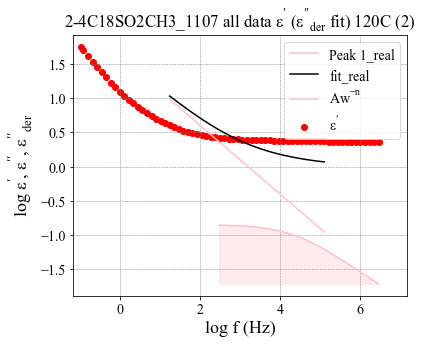

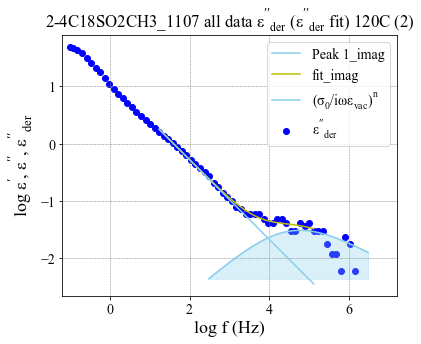

In [27]:
####################################################################################
##################### run this cell after you have good guesses ####################
####################################################################################

##### this part is the first fitting to imaginary derivative #####
# guesses and bounds in np.array and tuple, respectively
guess = guess_array(del_eps, tau_HN, a, b, eps_inf, sig, A, n, n2)
bnds = bounds_array(del_eps, tau_HN, a, b, eps_inf, sig, A, n, n2)

# use the sciPy optimize function to fit the curve
fit_result = minimize(fit_func_imag, guess, args=(x, y_imag_der),\
              method=algorithm,bounds=bnds,options={'maxiter':iterations})

print(fit_result)
params = fit_result.x

# save parameters in each list or variable
del_eps_fit = [params[i*4] for i in range(peak_number)]
tau_HN_fit = [params[i*4+1] for i in range(peak_number)]
a_fit = [params[i*4+2] for i in range(peak_number)]
b_fit = [params[i*4+3] for i in range(peak_number)]
eps_inf_fit = params[-5]
sig_fit = params[-4]
A_fit = params[-3]
n_fit = params[-2]
n2_fit = params[-1]

# calculate chi-square
# maybe least square error (params.fun) is more reliable
new_y = eps_imag_function(x, del_eps_fit, tau_HN_fit, a_fit, b_fit, eps_inf_fit, sig, A_fit, n_fit, n2_fit)
deviation = ((np.linalg.norm(np.log10(new_y) - y_imag_der)**2)/np.abs(y_imag_der))
chi_sq = np.sum(deviation)

### make a table of values ###
# convert from log10 to regular number in table to save
par_table = pd.DataFrame()
par_table['del_eps'] = 10**(np.array(del_eps_fit))
par_table['tau_HN (s)'] = 10**(np.array(tau_HN_fit))
par_table['a'] = a_fit
par_table['b'] = b_fit
par_table['eps_inf'] = 10**(np.array(eps_inf_fit))
par_table['sig [S/cm]'] = 10**(sig_fit)/100
par_table['A'] = 10**(np.array(A_fit))
par_table['n'] = n_fit
par_table['n2'] = n2_fit
par_table['chi-square'] = chi_sq
par_table['least-sq error'] = fit_result.fun

par_table = par_table.T
par_table = par_table.rename(columns={i:'Peak {0} (imag fit)'.format(i+1) for i in range(par_table.shape[1])})

### This cell saves parameters, data points of each peak and total fit, and figures ###
### angular frequency --> frequency ###
### plots use "frequency" (x) ###
### functions should take "angular frequency" (x) - np.log10(np.pi*2) ###

# make a directory to save files
# save_dir = os.path.join(filename[:-5], "%d peak(s)" % peak_number)
save_dir = os.path.join(filename[:-5])

"""if save_results:
    try:
        os.mkdir(filename[:-5])
    except FileExistsError:
        print('Directory already exists.')
"""
if save_results:
    try:
        os.mkdir(save_dir)
    except FileExistsError:
        print('Directory already exists.')

# save parameter table as a csv file
dir_and_filename = os.path.join(save_dir,filename[:-5])
if save_results:
    par_table.to_csv(dir_and_filename+' params {0}.csv'.format(temperature))

### plot results ###
# x for full data #
x_full_plot = x_full - np.log10(np.pi*2)

# x for total fit #
# convert x from angular frequency to frequency
x_for_fit = np.linspace(x[0] - np.log10(np.pi*2), x[-1] - np.log10(np.pi*2), 100) # use for total fit
x_for_fit_calc = np.linspace(x[0], x[-1], 100)

# a list to concatenate all the data points
data_list = []
empty_df = pd.DataFrame()
empty_df['Imag der fit'] = np.empty((100)).fill(np.nan)
data_list.append(empty_df)

##### Plot Real #####
plt.figure(figsize=(6,4.8))
plt.title(filename[:-5]+" $\epsilon'$ ($\epsilon''_{{der}}$ fit) {0}".format(temperature))
plt.scatter(x_full_plot, log_eps_real, c='r', label="$\u03B5'$")
raw_real = pd.DataFrame({'log freq [Hz]': x_full_plot, 'log eps real (raw)': log_eps_real})
data_list.append(raw_real)
total_fit_real = eps_real_function(x_for_fit_calc, del_eps_fit, tau_HN_fit, a_fit, b_fit, eps_inf_fit, sig, A_fit, n_fit, n2_fit)
real_fit = pd.DataFrame({'log freq [Hz]': x_for_fit, 'log eps real (fit)': total_fit_real})
data_list.append(real_fit) # add the dataframe to the list

for i in range(peak_number):
    # x for each peak #
    # should it be angular frequency? frequency (-np.log10(np.pi*2)) ??
    log_peak_mid_freq = np.log10((10**tau_HN_fit[i])**(-1)) - np.log10(np.pi*2)
    x_for_peak = np.linspace(log_peak_mid_freq - 2, log_peak_mid_freq + 2, 100)
    x_for_peak_calc = x_for_peak + np.log10(2*np.pi)
    
    # calc each eps value of peak #
    peak = HN_eqn_real(x_for_peak_calc, del_eps_fit[i], tau_HN_fit[i], a_fit[i], b_fit[i])
    plt.plot(x_for_peak, np.log10(peak),c='pink',label='Peak {0}_real'.format(i+1))
    plt.fill_between(x_for_peak, np.log10(peak), np.log10(peak).min(), interpolate=True,color='pink', alpha=0.3)
    peak_info = pd.DataFrame({'log freq [Hz]':x_for_peak, 'log eps real peak {0}'.format(i+1): np.log10(peak)})
    data_list.append(peak_info) # add the dataframe to the list
plt.plot(x_for_fit, np.log10(total_fit_real), c='k', label='fit_real')
plt.plot(x_for_fit, np.log10(pol_term(x_for_fit_calc, A_fit, n2_fit)), c='pink', label='$Aw^{-n}$')
pol_term_df = pd.DataFrame({'log freq [Hz]': x_for_fit, 'polarization term': np.log10(pol_term(x_for_fit_calc, sig_fit, n_fit))})
data_list.append(pol_term_df) # add the dataframe to the list
plot_options()
plt.xlim(-1.2,7.2)
plt.xlabel("log f (Hz)")
#if save_results:
#    plt.savefig(dir_and_filename+' fit real (imag fit) {0}.png'.format(temperature), dpi=300)
plt.show()

#####################
##### Plot Imag #####
plt.figure(figsize=(6,4.8))
plt.title(filename[:-5]+" $\epsilon''_{{der}}$ ($\epsilon''_{{der}}$ fit) {0}".format(temperature))
plt.scatter(x_full_plot, log_eps_imag_der, c='b', label="$\u03B5''_{der}$")
raw_imag = pd.DataFrame({'log freq [Hz]': x_full_plot, 'log eps imag der (raw)': log_eps_real})
data_list.append(raw_imag)
total_fit_imag = eps_imag_function(x_for_fit_calc, del_eps_fit, tau_HN_fit, a_fit, b_fit, eps_inf_fit, sig_fit, A_fit, n_fit, n2_fit)
imag_fit = pd.DataFrame({'log freq [Hz]': x_for_fit, 'log eps imag (fit)': total_fit_imag})
data_list.append(imag_fit) # add the dataframe to the list
for i in range(peak_number):
    # x for each peak #
    # should it be angular frequency? frequency (-np.log10(np.pi*2)) ??
    log_peak_mid_freq = np.log10((10**tau_HN_fit[i])**(-1)) - np.log10(np.pi*2)
    x_for_peak = np.linspace(log_peak_mid_freq - 2, log_peak_mid_freq + 2, 100)
    x_for_peak_calc = x_for_peak + np.log10(2*np.pi)
    
    # calc each eps value of peak #
    peak = HN_eqn_imag(x_for_peak_calc, del_eps_fit[i], tau_HN_fit[i], a_fit[i], b_fit[i])
    plt.plot(x_for_peak, np.log10(peak),c='skyblue',label='Peak {0}_imag'.format(i+1))
    plt.fill_between(x_for_peak,np.log10(peak), np.log10(peak).min(),where=np.log10(peak)>np.log10(peak[0]), interpolate=True,color='skyblue', alpha=0.3)
    peak_info = pd.DataFrame({'log freq [Hz]':x_for_peak, 'log eps imag der peak {0}'.format(i+1): np.log10(peak)})
    data_list.append(peak_info) # add the dataframe to the list

plt.plot(x_for_fit, np.log10(total_fit_imag), c='y', label='fit_imag')
plt.plot(x_for_fit, np.log10(sig_term(x_for_fit_calc, sig_fit, n_fit)), c='skyblue', label="$(\sigma_{0}/i\omega\epsilon_{vac})^{n}$")
sig_term_df = pd.DataFrame({'log freq [Hz]': x_for_fit, 'sigma term': np.log10(sig_term(x_for_fit_calc, sig_fit, n_fit))})
data_list.append(sig_term_df) # add the dataframe to the list
plot_options()
plt.xlabel("log f (Hz)")
plt.xlim(-1.2,7.2)
if save_results:
    plt.savefig(dir_and_filename+' fit imag der (imag fit) {0}.png'.format(temperature), dpi=300)
plt.show()
#####################

empty_df2 = pd.DataFrame()
empty_df2[' '] = np.empty((100)).fill(np.nan)
empty_df2['Real fit'] = np.empty((100)).fill(np.nan)
data_list.append(empty_df2)

data_comb = pd.concat(data_list, axis=1, sort=False)
if save_results:
    data_comb.to_csv(dir_and_filename+' fit data {0}.csv'.format(temperature))

     fun: 0.007196135605371119
     jac: array([-0.00361824,  0.00052819, -0.00064033,  0.0014651 , -0.04596466,
        0.        , -0.00195153,  0.        ,  0.00761994])
 message: 'Optimization terminated successfully'
    nfev: 233
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([-0.54788623, -4.76681965,  0.19065655,  0.92675717,  0.34806078,
       -7.97329275,  1.62025137,  0.69595032,  0.69904339])
                Peak 1 (imag fit)  Peak 1 (real fit)
del_eps              1.429795e-01       2.832134e-01
tau_HN (s)           5.328552e-06       1.710726e-05
a                    6.033159e-01       1.906566e-01
b                    6.470772e-01       9.267572e-01
eps_inf              1.000000e+00       2.228747e+00
sig [S/cm]           1.063426e-10       1.063426e-10
A                    1.000000e+02       4.171107e+01
n                    6.959503e-01       6.959503e-01
n2                   5.000000e-01       6.990434e-01
chi-square           1.129165e+04      

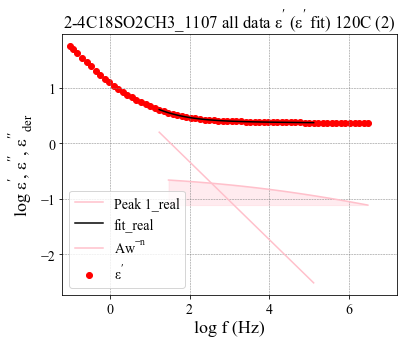

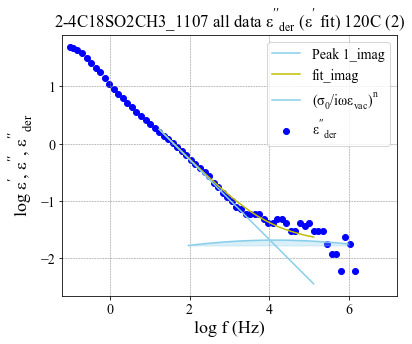

In [28]:
####################################################################################
######## This part is the second fitting to real part with previous guesses ########
####################################################################################

del_eps2 = del_eps_fit
tau_HN2 = tau_HN_fit
a2 = a_fit
b2 = b_fit
eps_inf2 = eps_inf_fit
sig2 = sig_fit
A2 = A_fit
n2 = n_fit
n22 = n2_fit

guess2 = guess_array(del_eps2, tau_HN2, a2, b2, eps_inf2, sig2, A2, n2, n22)

fit_result2 = minimize(fit_func_real, guess2, args=(x, y_real),\
              method=algorithm,bounds=bnds,options={'maxiter':iterations})

print(fit_result2)
params2 = fit_result2.x

# save parameters in each item
del_eps_fit2 = [params2[i*4] for i in range(peak_number)]
tau_HN_fit2 = [params2[i*4+1] for i in range(peak_number)]
a_fit2 = [params2[i*4+2] for i in range(peak_number)]
b_fit2 = [params2[i*4+3] for i in range(peak_number)]
eps_inf_fit2 = params2[-5]
sig_fit2 = params2[-4]
A_fit2 = params2[-3]
n_fit2 = params2[-2]
n2_fit2 = params2[-1]

### calculate chi-square ###
new_y = eps_real_function(x, del_eps_fit2, tau_HN_fit2, a_fit2, b_fit2, eps_inf_fit2, sig2, A_fit2, n_fit2, n2_fit2)
deviation = np.abs((np.linalg.norm(np.log10(new_y) - y_real)**2)/y_real)
chi_sq2 = np.sum(deviation)

### make a table of values ###
# convert to regular number from log10 # 

par_table2 = pd.DataFrame()
par_table2['del_eps'] = 10**(np.array(del_eps_fit2))
par_table2['tau_HN (s)'] = 10**(np.array(tau_HN_fit2))
par_table2['a'] = a_fit2
par_table2['b'] = b_fit2
par_table2['eps_inf'] = 10**(np.array(eps_inf_fit2))
par_table2['sig [S/cm]'] = 10**(sig_fit2)/100
par_table2['A'] = 10**(np.array(A_fit2))
par_table2['n'] = n_fit2
par_table2['n2'] = n2_fit2
par_table2['chi-square'] = chi_sq2
par_table2['least-sq error'] = fit_result2.fun

par_table2 = par_table2.T
par_table2 = par_table2.rename(columns={i:'Peak {0} (real fit)'.format(i+1) for i in range(par_table2.shape[1])})
par_table_new = pd.concat([par_table, par_table2], axis=1, sort=False)
print(par_table_new)

##### Plot Real #####
plt.figure(figsize=(6,4.8))
plt.title(filename[:-5]+" $\epsilon'$ ($\epsilon'$ fit) {0}".format(temperature))
plt.scatter(x_full_plot, log_eps_real, c='r', label="$\u03B5'$")
total_fit_real = eps_real_function(x_for_fit_calc, del_eps_fit2, tau_HN_fit2, a_fit2, b_fit2, eps_inf_fit2, sig2, A_fit2, n_fit2, n2_fit2)
real_fit = pd.DataFrame({'log freq [Hz]': x_for_fit, 'log eps real (fit)': total_fit_real})
data_list.append(real_fit) # add the dataframe to the list
for i in range(peak_number):
    # x for each peak #
    # should it be angular frequency? frequency (-np.log10(np.pi*2)) ??
    log_peak_mid_freq = np.log10((10**tau_HN_fit2[i])**(-1)) - np.log10(np.pi*2)
    x_for_peak = np.linspace(log_peak_mid_freq - 2.5, log_peak_mid_freq + 2.5, 100)
    x_for_peak_calc = x_for_peak + np.log10(2*np.pi)
    
    # calc each eps value of peak #
    peak = HN_eqn_real(x_for_peak_calc, del_eps_fit2[i], tau_HN_fit2[i], a_fit2[i], b_fit2[i])
    plt.plot(x_for_peak, np.log10(peak),c='pink',label='Peak {0}_real'.format(i+1))
    plt.fill_between(x_for_peak, np.log10(peak),np.log10(peak).min(), interpolate=True,color='pink', alpha=0.3)
    peak_info = pd.DataFrame({'log freq [Hz]':x_for_peak, 'log eps real peak {0}.format(i+1)': np.log10(peak)})
    data_list.append(peak_info) # add the dataframe to the list
plt.plot(x_for_fit, np.log10(total_fit_real), c='k', label='fit_real')
plt.plot(x_for_fit, np.log10(pol_term(x_for_fit_calc, A_fit2, n2_fit2)), c='pink', label='$Aw^{-n}$')
pol_term_df = pd.DataFrame({'log freq [Hz]': x_for_fit, 'polarization term': np.log10(pol_term(x_for_fit_calc, A_fit2, n2_fit2))})
data_list.append(pol_term_df) # add the dataframe to the list
plot_options()
plt.xlabel("log f (Hz)")
plt.xlim(-1.2,7.2)
if save_results:
    plt.savefig(dir_and_filename+' fit real (real fit) {0}.png'.format(temperature), dpi=300)
plt.show()

#####################
##### Plot Imag #####
plt.figure(figsize=(6,4.8))
plt.title(filename[:-5]+" $\epsilon''_{{der}}$ ($\epsilon'$ fit) {0}".format(temperature))
plt.scatter(x_full_plot, log_eps_imag_der, c='b', label="$\u03B5''_{der}$")
total_fit_imag = eps_imag_function(x_for_fit_calc, del_eps_fit2, tau_HN_fit2, a_fit2, b_fit2, eps_inf_fit2, sig2, A_fit2, n_fit2, n2_fit2)
imag_fit = pd.DataFrame({'log freq [Hz]': x_for_fit, 'log eps imag (fit)': total_fit_imag})
data_list.append(imag_fit) # add the dataframe to the list
for i in range(peak_number):
    # x for each peak #
    # should it be angular frequency? frequency (-np.log10(np.pi*2)) ??
    log_peak_mid_freq = np.log10((10**tau_HN_fit2[i])**(-1)) - np.log10(np.pi*2)
    x_for_peak = np.linspace(log_peak_mid_freq - 2, log_peak_mid_freq + 2, 100)
    x_for_peak_calc = x_for_peak + np.log10(2*np.pi)
    
    # calc each eps value of peak #
    peak = HN_eqn_imag(x_for_peak_calc, del_eps_fit2[i], tau_HN_fit2[i], a_fit2[i], b_fit2[i])
    plt.plot(x_for_peak, np.log10(peak),c='skyblue',label='Peak {0}_imag'.format(i+1))
    plt.fill_between(x_for_peak,np.log10(peak),np.log10(peak).min(), interpolate=True,color='skyblue', alpha=0.3)
    peak_info = pd.DataFrame({'log freq [Hz]':x_for_peak, 'log eps imag der peak {0}'.format(i+1): np.log10(peak)})
    data_list.append(peak_info) # add the dataframe to the list

plt.plot(x_for_fit, np.log10(total_fit_imag), c='y', label='fit_imag')
plt.plot(x_for_fit, np.log10(sig_term(x_for_fit_calc, sig_fit2, n_fit2)), c='skyblue', label="$(\sigma_{0}/i\omega\epsilon_{vac})^{n}$")
sig_term_df = pd.DataFrame({'log freq [Hz]': x_for_fit, 'sigma term': np.log10(sig_term(x_for_fit_calc, sig_fit2, n_fit2))})
data_list.append(sig_term_df) # add the dataframe to the list
plot_options()
plt.xlabel("log f (Hz)")
plt.xlim(-1.2,7.2)
#if save_results:
#    plt.savefig(dir_and_filename+' fit imag der (real fit) {0}.png'.format(temperature), dpi=300)
plt.show()
#####################

data_comb = pd.concat(data_list, axis=1, sort=False)

# save updated parameter table and points
if save_results:
    par_table_new.to_csv(dir_and_filename+' params {0}.csv'.format(temperature))
    data_comb.to_csv(dir_and_filename+' fit data {0}.csv'.format(temperature))

## How to use
Run the first cell to see preliminary plot with initial guesses.  
Fist cell shows sliced data range and the plot based on your initial guess.  
Edit `filename` and `wb_name` to select target file and spreadsheet.  

In order to slice the data,  
Edit `fit_lowf` to include some of polarization range (low f). Make sure the data ends in the middle of slope.  
Edit `fit_highf` to remove noise at high frequency range.  
Edit `peak_number` to set how many peaks are in the data.  
Edit `x_low`, `x_high`, `y_low`, and `y_high` to set the x and y axis range of plots.  
You can also change the number of iterations `iterations`, fitting methods of your choice `algorithm`.
Please see `Fitting equation` section and below to see specific guide on guess variables.
After run the first cell, the first figures show the preliminary fitting curves with initial guesses.  

After fitting, the program automatically generate a directory named as the input filename, duplicate and save the fitting results (figures, fitting parameters, and points (of each fitting curves, total fit, and raw data) as the same filename (with ends of params, points, ...) of the Excel file as either .png or .csv file.  
Edit `save_results` to either `True` or `False` to save or not to save resulting files.  

After you get close preliminary curves to the experimental data with initial guesses, run the second cell, which fits $\varepsilon''_{der}$. Check the fit quality of $\varepsilon''_{der}$, it is okay even if you do not have a good fit to $\varepsilon'$ yet since the first fit only deals with the parameters in imaginary terms. If the fit is good to $\varepsilon''_{der}$, run the next cell to fit $\varepsilon'$.  

If the `save_results` is `True`, the program will generate a folder with figures, fitting parameters, and data points of each fitting (full fit, each peak, and the raw data) from both fittings.

## Fitting equation
#### $$\varepsilon^{*}=\varepsilon_{\infty}+\sum_{j}\frac{\Delta\varepsilon_{j}}{(1+(i\omega\tau_{HN,j})^{a_{j}})^{b_{j}}}+\
(\frac{\sigma_{0}}{i\omega\varepsilon_{vac}})^{n}+A\omega^{-n_{2}}$$  
$$where\;\varepsilon^{*}=\varepsilon'-i\varepsilon''$$


### Constants and x value (frequency)
$\varepsilon_{vac}$ Permittivity of vacuum $(8.8542\times10^{-12}\frac{F}{m})$  
$\omega$ Angular frequency $(2\pi f)$  

References  
1. Robert J. Klein, DIELECTRIC PROPERTIES OF CONDUCTIVE IONOMERS, A Thesis in Materials Science and Engineering
2. Fragiadakis D, Dou S, Colby RH, Runt J (2008) Macromolecules 41:5723–5728
3. Fan F, Wang Y, Sokolov AP (2013) Macromolecules 46:9380–9389  

## Guesses  
The guesses should be in log10 scale (e.g. $2$ for $10^2$) (except for `a`, `b`, `n`, and `n2`). The variables are either lists of guesses (form of [num1, num2, ...], guesses for HN term) or float (a single number). The order of each element in each guesses should be the same ([param1, param2, ...], and [other_param1, other_param2, ...]). The total number of elements should be larger or the same as `peak_number`. Each guess has its own bound and the number of elements should be the same as that of the elements (variables named as either width or range).  

### HN term guesses (Complex)
Since this term can be more than one, the guesses are lists.  
$Havriliak-Negami\; term\; (Complex) = \sum_{j}\frac{\Delta\varepsilon_{j}}{(1+(i\omega\tau_{HN,j})^{a_{j}})^{b_{j}}}$  
$\Delta\varepsilon_{j}$ Dielectric strength (`del_eps`, list of guesses)  
$\tau_{HN,j}$ HN relaxation time (`tau_HN`, list of guesses)  
${a_{j}}, {b_{j}}$ shape parameters (`a`, `b`, list of guesses)  

### Imaginary term guesses
$Sigma\; term\; (Imaginary) = (\frac{\sigma_{0}}{i\omega\varepsilon_{vac}})^{n}$  
$\sigma_{0}$ Ionic conductivity (`sig`, float)  
$n$ Slope of polarization (`n`, float)

### Real term guesses
$\varepsilon_{\infty}$ Dielectric constant at high frequency (`eps_inf`, float)  
$Polarization\; term\; (Real) = A\omega^{-n_{2}}$  
$A$ Height of polarization (`A`, float)  
${-n_{2}}$ Slope of polarization (`n2`, float)  

### Contact
Please let me know if you have questions.  
Bumjun Park  
`bpark4@nd.edu`  
(05-16-2020)  